In [1]:
import boto3
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytz
import datetime

from statistics import mean

In [2]:
def unix_to_singapore_time(unix_timestamp):
    utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)

    sgt_timezone = pytz.timezone('Asia/Singapore')
    sgt_datetime = utc_datetime.replace(tzinfo=pytz.utc).astimezone(sgt_timezone)

    return sgt_datetime

def convert_to_float(arr):
    return np.array([[float(cell) for cell in row] for row in arr])

In [3]:
file = open('keys.txt', 'r')
acki = file.readline().strip()
asak = file.readline().strip()


In [4]:
csv_file_name = 'dump.csv'

In [5]:
ddb = boto3.resource(
    "dynamodb",
    region_name="ap-southeast-1",
    aws_access_key_id=acki,
    aws_secret_access_key=asak
    )
raw = ddb.Table("raw-data")
items = raw.scan()['Items']

In [6]:
data = []

with open(csv_file_name, 'w', newline='') as csvfile:
    fieldnames = items[0].keys() if items else []
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for item in items:
        writer.writerow(item)
        data.append({
            'timestamp': item['timestamp'],
            'therm': np.array(item['therm']), 
            'ambient_temp': item['ambient_temp'],
            'gyr': item['gyr'],
            'has_puddle': item['has_puddle'],
            'has_motion': item['has_motion']
        })
        

In [7]:
df = pd.DataFrame(data)
df['timestamp'] = df['timestamp'].astype(int)
df['timestamp']//=1000

df['therm'] = df['therm'].apply(convert_to_float)
df['ambient_temp'] = df['ambient_temp'].astype(float)

df = df.sort_values(by='timestamp')

In [8]:
# for i, row in df.iterrows():
#     if row['has_motion'] == 0:
#         plt.imshow(row['therm'], cmap='hot', interpolation='nearest', clim=(15, 25))
#         plt.colorbar() 
#         plt.title(str(unix_to_singapore_time(row['timestamp'])) + (" PUDDLE" if row['has_puddle'] else " DRY"))
#         plt.show()

In [9]:
ts = np.stack(df['therm'])
amb = np.array(df['ambient_temp'])

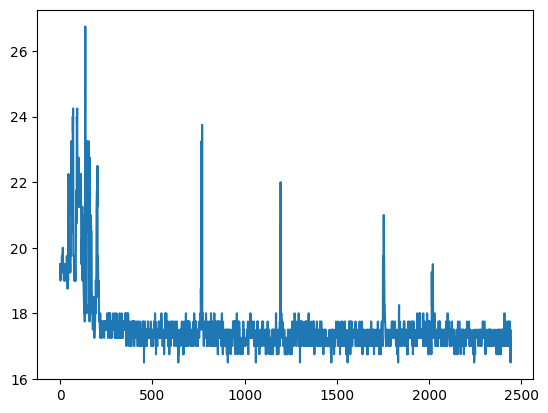

In [10]:
plt.plot(ts[:,3,3])

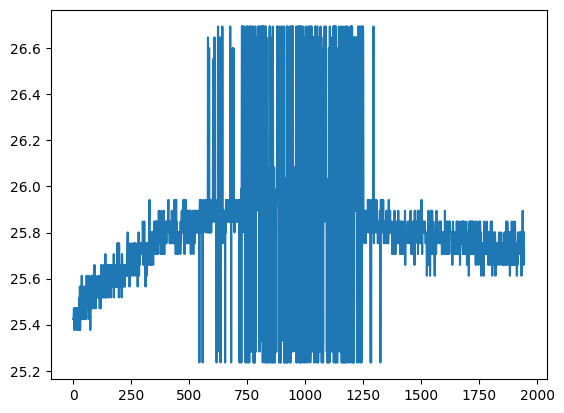

In [11]:
plt.plot(amb[500:])

In [12]:
pix1 = 4
pix2 = 4

print(mean(ts[:,pix1,pix2][500:1000]), mean(ts[:,pix1,pix2][1500:2000]))

17.602 17.5425


In [13]:
puds = []
pud_devs = []

ambs = []

idxs = [
    [400, 500],
    [1000,1100],
    [1500,1600],
    [2200, 2300]
]

for idx in idxs:
    puds.append(np.array(list(np.sum(a) / 64 for a in ts[idx[0]:idx[1]])))
    
    pud_devs.append(np.array(list(np.std(a) for a in ts[idx[0]:idx[1]])))
    
    ambs.append(np.array(amb[idx[0]:idx[1]]))

Puddle 8.169760110294119
No Puddle 8.770652573529414
Puddle 8.960735294117649
No Puddle 8.73858685661765


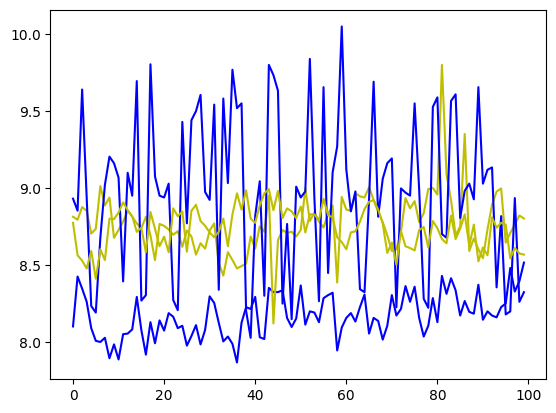

In [14]:
for i in range(len(puds)):
    if i % 2 == 0:
        plt.plot(ambs[i] - puds[i], color='b')
        
        print('Puddle', mean(ambs[i] - puds[i]))
    else:
        plt.plot(ambs[i] - puds[i], color='y')
        
        print('No Puddle', mean(ambs[i] - puds[i]))
        

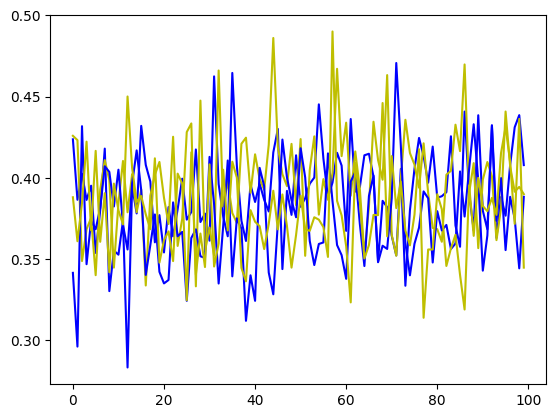

In [15]:
for i in range(len(puds)):
    if i % 2 == 0:
        plt.plot(pud_devs[i], color='b')

    else:
        plt.plot(pud_devs[i], color='y')